* Issue [#299](https://github.com/salgo60/Stockholm_Archipelago_Trail/issues/299)
* Notebook [299_stat_SAT.ipynb](https://github.com/salgo60/Stockholm_Archipelago_Trail/blob/main/Notebook/299_stat_SAT.ipynb)

In [1]:
import time
import datetime  
start_time = time.time()
start_str = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
print(f"Started: {start_str}")


Started: 2025-11-13 10:25


In [2]:
import requests, json
from lxml import etree
from shapely.geometry import LineString
from shapely.ops import unary_union
from collections import Counter, defaultdict
from requests.adapters import HTTPAdapter, Retry
from shapely.geometry import mapping
from pathlib import Path
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd  

OSM_REL = 19012437  # SAT superrelation
EXCLUDE_ROLES = {"alternate", "detour", "connection"}
trail_qid = "Q131318799"

# ---------- Nätverk: session med retry + no-cache ----------
def make_session():
    s = requests.Session()
    retries = Retry(total=5, backoff_factor=1.2,
                    status_forcelist=[429, 500, 502, 503, 504])
    s.mount("https://", HTTPAdapter(max_retries=retries))
    return s

SESSION = make_session()

def fetch_relation_full_with_headers(rel_id: int, timeout=60, session=SESSION):
    url = f"https://api.openstreetmap.org/api/0.6/relation/{rel_id}/full"
    r = session.get(
        url,
        timeout=timeout,
        headers={
            "Cache-Control": "no-cache",
            "Pragma": "no-cache",
            "User-Agent": "sat-debug/0.1 (+contact)"
        },
    )
    r.raise_for_status()
    root = etree.fromstring(r.content)
    return root, r.headers

# ---------- Medlems-hjälpare ----------
def relation_members(xml_root, rel_id: int):
    members = defaultdict(list)
    for rel in xml_root.findall("relation"):
        if rel.attrib["id"] == str(rel_id):
            for m in rel.findall("member"):
                mtype = m.attrib.get("type")
                mid = int(m.attrib.get("ref"))
                role = m.attrib.get("role", "")
                members[mtype].append((mid, role))
            break
    return members

def summarize_members(members, title=""):
    if title:
        print(f"== {title} ==")
    for t in ("relation", "way", "node"):
        lst = members.get(t, [])
        if not lst:
            continue
        roles = [r for _, r in lst]
        print(f"{t}: {len(lst)} st | roller: {dict(Counter(roles))}")

def member_relation_ids(xml_root, rel_id: int):
    ids = set()
    for rel in xml_root.findall("relation"):
        if rel.attrib["id"] == str(rel_id):
            for m in rel.findall("member"):
                if m.attrib.get("type") == "relation":
                    ids.add(int(m.attrib["ref"]))
            break
    return ids

def member_way_ids(xml_root, rel_id: int, exclude_roles=EXCLUDE_ROLES):
    ids = set()
    for rel in xml_root.findall("relation"):
        if rel.attrib["id"] == str(rel_id):
            for m in rel.findall("member"):
                if m.attrib.get("type") == "way":
                    role = m.attrib.get("role", "")
                    if role not in exclude_roles:
                        ids.add(m.attrib["ref"])
            break
    return ids

# ---------- Ways -> koordinater ----------
def ways_by_id_from_xml(xml_root, allowed_way_ids: set[str]):
    nodes = {n.attrib["id"]: (float(n.attrib["lon"]), float(n.attrib["lat"]))
             for n in xml_root.findall("node")}
    ways = {}
    for w in xml_root.findall("way"):
        wid = w.attrib["id"]
        if wid not in allowed_way_ids:
            continue
        coords = []
        for nd in w.findall("nd"):
            ref = nd.attrib["ref"]
            if ref in nodes:
                coords.append(nodes[ref])
        if len(coords) > 1:
            ways[wid] = coords
    return ways

# ---------- Wikidata sections with extended props ----------
def fetch_wikidata_sections(trail_qid="Q131318799"):
    sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
    sparql.setQuery(f"""
    SELECT ?section ?sectionLabel_sv ?sectionLabel_en 
           ?website_sv ?website_en 
           ?osmRel ?code ?email ?commonscat
    WHERE {{
      wd:{trail_qid} wdt:P527 ?section .

      OPTIONAL {{
        ?section p:P856 ?stmt_sv.
        ?stmt_sv ps:P856 ?website_sv.
        ?stmt_sv pq:P407 wd:Q9027.
      }}

      OPTIONAL {{
        ?section p:P856 ?stmt_en.
        ?stmt_en ps:P856 ?website_en.
        ?stmt_en pq:P407 wd:Q1860.
      }}

      OPTIONAL {{ ?section wdt:P402 ?osmRel }}
      OPTIONAL {{ ?section wdt:P1401 ?code }}
      OPTIONAL {{ ?section wdt:P968 ?email }}
      OPTIONAL {{ ?section wdt:P373 ?commonscat }}

      ?section rdfs:label ?sectionLabel_en. FILTER(lang(?sectionLabel_en)="en")
      ?section rdfs:label ?sectionLabel_sv. FILTER(lang(?sectionLabel_sv)="sv")
    }}
    """)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()

    mapping = {}
    for r in results["results"]["bindings"]:
        osm_rel = r.get("osmRel", {}).get("value")
        if osm_rel:
            rid = int(osm_rel)
            mapping[rid] = {
                "QID": r["section"]["value"].split("/")[-1],
                "Labelsv": r.get("sectionLabel_sv", {}).get("value"),
                "Labelen": r.get("sectionLabel_en", {}).get("value"),
                "website_sv": r.get("website_sv", {}).get("value") if "website_sv" in r else None,
                "website_en": r.get("website_en", {}).get("value") if "website_en" in r else None,
                "P1401": r.get("code", {}).get("value") if "code" in r else None,
                "P968": r.get("email", {}).get("value") if "email" in r else None,
                "P373": r.get("commonscat", {}).get("value") if "commonscat" in r else None,
            }
    return mapping

# ---------- Körning ----------
section_meta = fetch_wikidata_sections()

# 1) Hämta superrelationen
root_super, hdr = fetch_relation_full_with_headers(OSM_REL)
print("HTTP Date:", hdr.get("Date"))
print("ETag:", hdr.get("ETag"))
print("Last-Modified:", hdr.get("Last-Modified"))

rel_version = rel_ts = None
for rel in root_super.findall("relation"):
    if rel.attrib["id"] == str(OSM_REL):
        rel_version = rel.attrib.get("version")
        rel_ts = rel.attrib.get("timestamp")
        break
print(f"Relation {OSM_REL} version: {rel_version} | timestamp: {rel_ts}")

# 2) Medlemsöversikt
members_super = relation_members(root_super, OSM_REL)
summarize_members(members_super, title=f"Relation {OSM_REL}")

# 3) Barnrelationer
ref_child_ids = member_relation_ids(root_super, OSM_REL)

present_child_ids = {int(r.attrib["id"])
                     for r in root_super.findall("relation")
                     if r.attrib["id"] != str(OSM_REL)}

missing_ids = sorted(ref_child_ids - present_child_ids)
extra_ids = sorted(present_child_ids - ref_child_ids)

print(f"Delrelationer (referenser): {len(ref_child_ids)}")
print(f"Delrelationer (hämtade element): {len(present_child_ids)}")
print("Saknas i /full:", missing_ids)
print("Överflödiga i /full:", extra_ids)

from shapely.geometry import LineString
from shapely.ops import unary_union
import shapely
import geopandas as gpd
from shapely.geometry import mapping

# 4) Per delrelation – hämta geometrier och mät highway-längder
failed_children = []
relation_data = {}

for rid in sorted(ref_child_ids):
    try:
        rxml, _ = fetch_relation_full_with_headers(rid)
        sub_way_ids = member_way_ids(rxml, rid)
        sub_ways = ways_by_id_from_xml(rxml, sub_way_ids)

        nodes = {n.attrib["id"]: (float(n.attrib["lon"]), float(n.attrib["lat"]))
                 for n in rxml.findall("node")}

        way_records = []
        for w in rxml.findall("way"):
            wid = w.attrib["id"]
            if wid not in sub_ways:
                continue
            coords = sub_ways[wid]
            if len(coords) < 2:
                continue
            tags = {t.attrib["k"]: t.attrib["v"] for t in w.findall("tag")}
            geom = LineString(coords)
            highway = tags.get("highway", "unknown")
            surface = tags.get("surface", "unknown")
            way_records.append({
                "rid": rid,
                "wid": wid,
                "geometry": geom,
                "highway": highway,
                "surface": surface
            })

        if not way_records:
            continue

        gdf_local = gpd.GeoDataFrame(way_records, crs="EPSG:4326").to_crs(3006)
        gdf_local["length_m"] = gdf_local.geometry.length
        relation_data[rid] = gdf_local

    except requests.HTTPError as e:
        failed_children.append((rid, str(e)))

if failed_children:
    print("⚠️ Varning: kunde inte hämta vissa delrelationer:")
    for rid, err in failed_children:
        print(f"  - {rid}: {err}")

# 5) Slå ihop till GeoDataFrame med metadata
all_gdfs = []
for rid, gdf_local in relation_data.items():
    meta = section_meta.get(rid, {})
    for k, v in meta.items():
        gdf_local[k] = v
    all_gdfs.append(gdf_local)

gdf = gpd.GeoDataFrame(pd.concat(all_gdfs, ignore_index=True), crs="EPSG:3006")
gdf = gdf.rename(columns={"rid": "OSM_REL"})

print(f"✅ Totalt {len(gdf)} vägelement från {len(relation_data)} etapper")

# 💾 Exportera GeoDataFrame direkt till GeoJSON
output_geojson = "SAT_full_299.geojson"
gdf.to_file(output_geojson, driver="GeoJSON")
print(f"💾 Sparade: {output_geojson} med metadata och highway/surface/längd")


HTTP Date: Thu, 13 Nov 2025 09:25:31 GMT
ETag: None
Last-Modified: None
Relation 19012437 version: 31 | timestamp: 2025-09-22T05:04:08Z
== Relation 19012437 ==
relation: 20 st | roller: {'': 20}
Delrelationer (referenser): 20
Delrelationer (hämtade element): 20
Saknas i /full: []
Överflödiga i /full: []
✅ Totalt 756 vägelement från 20 etapper
💾 Sparade: SAT_full_299.geojson med metadata och highway/surface/längd



📊 Längd per delrelation (etapp):
      Labelsv length_km
  SAT Arholma      10.7
      SAT Utö      16.6
      SAT Ålö      12.2
  SAT Runmarö      17.4
    SAT Nämdö      12.0
 SAT Landsort       9.1
  SAT Svartsö      14.5
  SAT Nåttarö       8.3
     SAT Rånö      10.6
 SAT Furusund       6.7
SAT Fjärdlång       8.7
 SAT Finnhamn       8.4
     SAT Lidö       7.8
    SAT Yxlan      20.6
     SAT Möja       9.8
     SAT Ornö      30.3
   SAT Grinda       8.3
 SAT Ingmarsö       8.4
 SAT Sandhamn       7.1
   SAT Brottö       1.0

Totallängd: 228.6 km


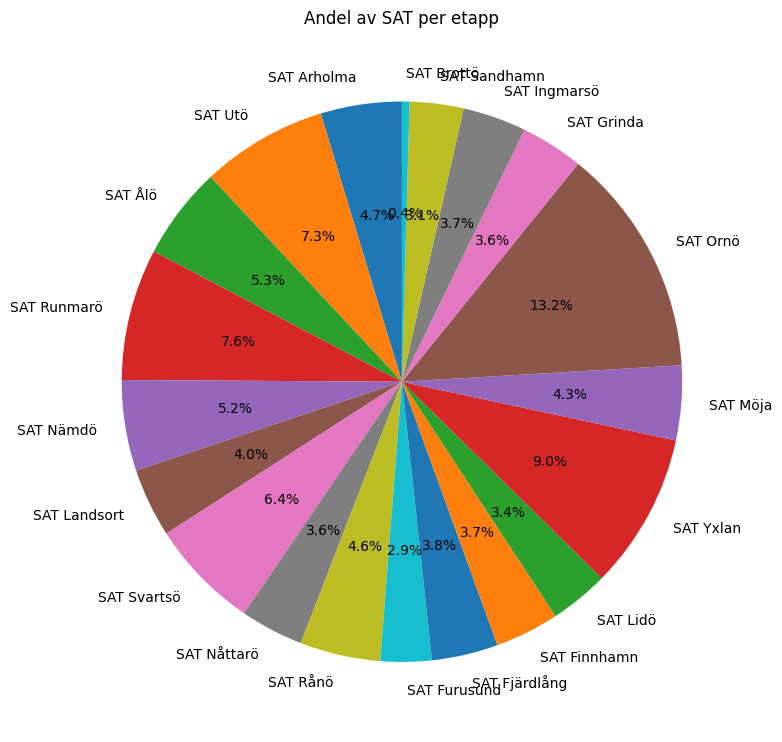


📊 Analys av vägtyper per etapp och totalt...

=== Totalt för hela SAT (meter och procent) ===
     highway length_m percent
        path  103,655    45.3
       track   39,589    17.3
unclassified   33,008    14.4
    tertiary   19,431     8.5
 residential   17,727     7.8
     service    7,365     3.2
     footway    7,319     3.2
     unknown      398     0.2
       steps      143     0.1
   secondary        5     0.0

=== Per etapp (topp 3 vägtyper per etapp) ===
SAT Arholma: path: 3.3 km (30.6%), service: 1.9 km (18.0%), tertiary: 1.9 km (17.6%)
SAT Brottö: unclassified: 1.0 km (98.7%), footway: 0.0 km (1.3%)
SAT Finnhamn: path: 6.5 km (76.6%), track: 2.0 km (23.4%)
SAT Fjärdlång: path: 6.9 km (78.4%), track: 1.5 km (16.6%), footway: 0.4 km (5.0%)
SAT Furusund: path: 3.7 km (55.0%), residential: 2.4 km (34.9%), service: 0.2 km (3.5%)
SAT Grinda: path: 5.8 km (70.2%), track: 2.4 km (28.6%), footway: 0.1 km (1.1%)
SAT Ingmarsö: path: 5.3 km (62.8%), unclassified: 2.2 km (26.5%), unk

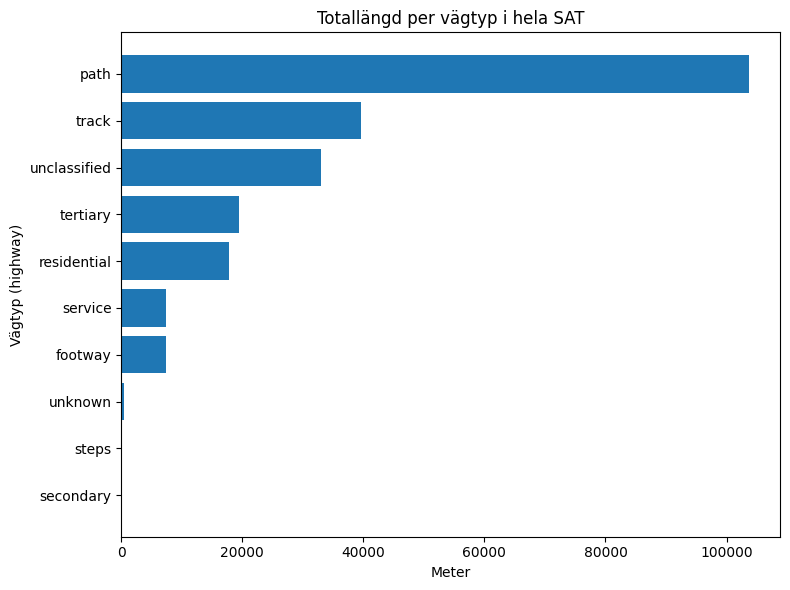

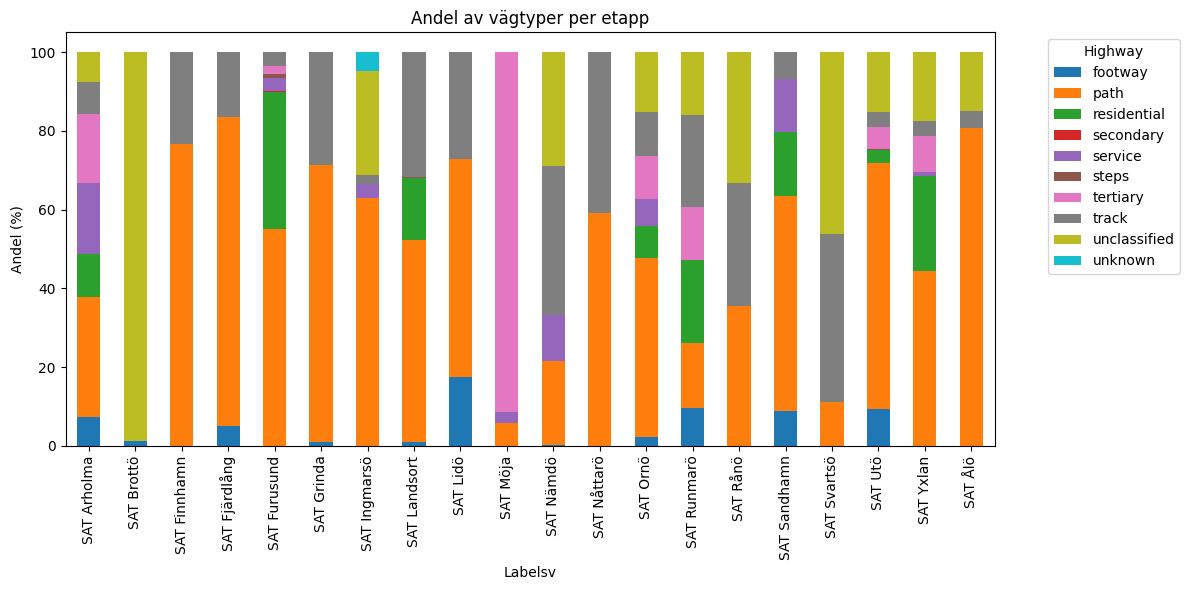


🚶‍♂️ Trapp-analys per etapp (highway=steps):
     Labelsv length_m length_km
SAT Furusund       60      0.06
SAT Landsort       33      0.03
     SAT Utö       29      0.03
   SAT Yxlan       11      0.01
  SAT Grinda        7      0.01
 SAT Arholma        3      0.00


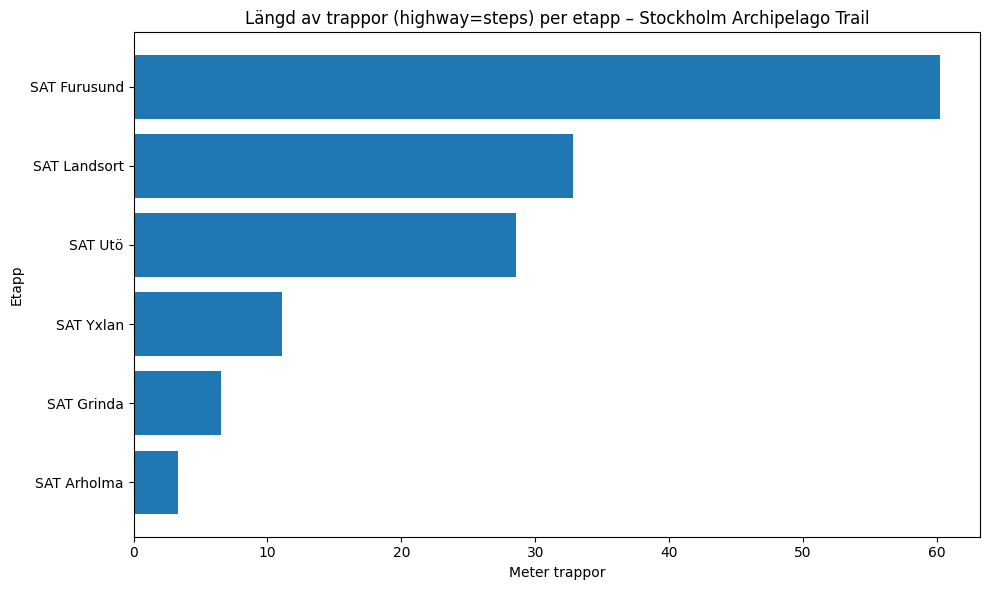

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
import folium

# === 7) Transformera till SWEREF 99 TM (EPSG:3006) ===
gdf = gdf.to_crs(3006)
gdf["length_m"] = gdf.geometry.length

# === 8) Sammanställning per etapp ===
summary = (
    gdf.groupby(["OSM_REL", "Labelsv"], dropna=False)["length_m"]
       .sum()
       .reset_index()
       .sort_values("OSM_REL")
)
summary["length_km"] = summary["length_m"] / 1000

print("\n📊 Längd per delrelation (etapp):")
print(summary[["Labelsv", "length_km"]].to_string(
    index=False, formatters={"length_km": "{:.1f}".format})
)
print(f"\nTotallängd: {summary['length_km'].sum():.1f} km")

# === 9) Cirkeldiagram (andel av total per etapp) ===
plt.figure(figsize=(8,8))
plt.pie(summary["length_km"], labels=summary["Labelsv"],
        autopct="%.1f%%", startangle=90)
plt.title("Andel av SAT per etapp")
plt.tight_layout()
plt.show()


# Automatisk färg per etapp
colors = [
    "#e41a1c", "#377eb8", "#4daf4a", "#984ea3",
    "#ff7f00", "#ffff33", "#a65628", "#f781bf", "#999999"
]
color_map = {rid: colors[i % len(colors)] for i, rid in enumerate(summary["OSM_REL"])}


# === 13) Highway-analys per etapp ===
print("\n📊 Analys av vägtyper per etapp och totalt...")

highway_stats = (
    gdf.groupby(["Labelsv", "highway"], dropna=False)["length_m"]
       .sum()
       .reset_index()
       .sort_values(["Labelsv", "length_m"], ascending=[True, False])
)

# Totalt per etapp
etapp_sum = highway_stats.groupby("Labelsv")["length_m"].sum().rename("total_m")
highway_stats = highway_stats.join(etapp_sum, on="Labelsv")
highway_stats["percent"] = 100 * highway_stats["length_m"] / highway_stats["total_m"]

# Totalt för hela SAT
total_highway = (
    gdf.groupby("highway", dropna=False)["length_m"]
       .sum()
       .reset_index()
       .sort_values("length_m", ascending=False)
)
total_highway["percent"] = (
    100 * total_highway["length_m"] / total_highway["length_m"].sum()
)

print("\n=== Totalt för hela SAT (meter och procent) ===")
print(total_highway.to_string(index=False,
      formatters={"length_m": "{:,.0f}".format, "percent": "{:.1f}".format}))

print("\n=== Per etapp (topp 3 vägtyper per etapp) ===")
for label, sub in highway_stats.groupby("Labelsv"):
    top = sub.nlargest(3, "length_m")
    txt = ", ".join(
        f"{row.highway}: {row.length_m/1000:.1f} km ({row.percent:.1f}%)"
        for _, row in top.iterrows()
    )
    print(f"{label}: {txt}")

# === 14) Trappor (steps) per etapp ===
steps = highway_stats.query("highway == 'steps'")
if not steps.empty:
    print("\n🚶‍♂️ Längd av trappor per etapp:")
    for _, row in steps.iterrows():
        print(f"  {row.Labelsv:20s} {row.length_m:7.0f} m")
else:
    print("\nIngen 'steps'-vägtyp hittades i data.")

# === 15) Visualisering – totalt SAT per vägtyp ===
plt.figure(figsize=(8,6))
plt.barh(total_highway["highway"], total_highway["length_m"])
plt.xlabel("Meter")
plt.ylabel("Vägtyp (highway)")
plt.title("Totallängd per vägtyp i hela SAT")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# === 16) Visualisering – andel per etapp (stacked bar) ===
pivot = highway_stats.pivot(index="Labelsv", columns="highway", values="percent").fillna(0)
pivot.plot(kind="bar", stacked=True, figsize=(12,6))
plt.ylabel("Andel (%)")
plt.title("Andel av vägtyper per etapp")
plt.legend(title="Highway", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# === 17) STEGANALYS ===
print("\n🚶‍♂️ Trapp-analys per etapp (highway=steps):")

steps_df = gdf[gdf["highway"] == "steps"].copy()
if steps_df.empty:
    print("❌ Inga trappsegment (highway=steps) hittades.")
else:
    steps_summary = (
        steps_df.groupby("Labelsv")["length_m"]
        .sum()
        .reset_index()
        .sort_values("length_m", ascending=False)
    )
    steps_summary["length_km"] = steps_summary["length_m"] / 1000
    print(steps_summary.to_string(
        index=False,
        formatters={"length_m": "{:,.0f}".format, "length_km": "{:.2f}".format})
    )

    plt.figure(figsize=(10,6))
    plt.barh(steps_summary["Labelsv"], steps_summary["length_m"])
    plt.xlabel("Meter trappor")
    plt.ylabel("Etapp")
    plt.title("Längd av trappor (highway=steps) per etapp – Stockholm Archipelago Trail")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


In [4]:
from SPARQLWrapper import SPARQLWrapper, JSON

sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
sparql.setReturnFormat(JSON)
sparql.setQuery("""
SELECT ?etapp ?etappLabel ?wwwsv WHERE {
  ?etapp wdt:P361 wd:Q131318799.
  OPTIONAL {
    ?etapp p:P856 ?statement.
    ?statement ps:P856 ?wwwsv.
    ?statement pq:P407 wd:Q9027.  # svenska
  }
  SERVICE wikibase:label { bd:serviceParam wikibase:language "sv,en". }
}
ORDER BY ?etapp
""")
res = sparql.query().convert()

# Bygg upp dict: { "SAT Arholma": "https://..." }
etapp_url = {}
for b in res["results"]["bindings"]:
    label = b["etappLabel"]["value"]
    url = b.get("wwwsv", {}).get("value")
    if url:
        etapp_url[label] = url


In [5]:
def link_etapp(label):
    url = etapp_url.get(str(label))
    return f"<a href='{url}' target='_blank'>{label}</a>" if url else label



In [6]:
from string import Template
from datetime import datetime as dt
import html  # vi använder html.escape här

def add_about_box(
    m,
    issue_number: int = 299,
    map_name: str = "Vägkaraktär & Användbarhet",
    created_date: str | None = None,
    repo: str = "salgo60/Stockholm_Archipelago_Trail",
    collapsed: bool = False,
    offset_px=(10, 54),  # (top, left) – 54px för att hamna snällt bredvid zoom
):
    """Superenkel, robust About-box som alltid syns."""
    if created_date is None:
        created_date = dt.now().strftime("%Y-%m-%d %H:%M")

    map_dom_id = m.get_name()
    box_id     = f"sat-about-{map_dom_id}"
    header_id  = f"{box_id}-hdr"
    issue_url  = f"https://github.com/{repo}/issues/{issue_number}"
    top, left  = offset_px
    collapsed_class = "sat-about-collapsed" if collapsed else ""

    links = [
        ("SAT Dashboard", "dashboard.html"),
        ("Project repo issues", "https://github.com/salgo60/Stockholm_Archipelago_Trail/issues?q=is%3Aissue"),
        ("Trail on OSM (rel 19012437)", "https://www.openstreetmap.org/relation/19012437"),
        ("Trail on Wikicommons", "https://commons.wikimedia.org/wiki/Category:Stockholm_Archipelago_Trail"),
        ("Official page", "https://stockholmarchipelagotrail.com/"),
        ("Unofficial FB group", "https://www.facebook.com/groups/2875020699552247"),
        ("Visit Sweden", "https://traveltrade.visitsweden.com/plan/news-sweden/Stockholm-Archipelago-Trail/"),
    ]
    links_html = "".join(
        f'<div><a href="{html.escape(u)}" target="_blank" style="text-decoration:none;">🔗 {html.escape(t)}</a></div>'
        for t, u in links
    )

    tpl = Template(r"""
<style>
  .sat-about {
    position: fixed; z-index: 10000;
    top: ${top}px; left: ${left}px;
    background: rgba(255,255,255,0.97);
    border: 2px solid #666; border-radius: 10px;
    box-shadow: 0 2px 6px rgba(0,0,0,0.25);
    font: 12px/1.35 -apple-system, system-ui, Segoe UI, Roboto, Helvetica, Arial, sans-serif;
    min-width: 240px; max-width: 320px; pointer-events: auto;
  }
  .sat-about-header { cursor: pointer; padding: 8px 10px; font-weight: 700;
    display: flex; align-items: center; gap: 6px; user-select: none;
    background: rgba(248,248,248,.9); border-bottom: 1px solid #e5e7eb; }
  .sat-about-body { padding: 8px 10px 10px 10px; }
  .sat-about-collapsed .sat-about-body { display: none; }
  .sat-chevron { margin-left: auto; transition: transform .15s ease-in-out; }
  .sat-about-collapsed .sat-chevron { transform: rotate(-90deg); }
  .sat-links { margin-top: 6px; padding-top: 6px; border-top: 1px solid #e5e7eb; }
</style>

<div id="${box_id}" class="sat-about ${collapsed_class}">
  <div id="${header_id}" class="sat-about-header" title="Click to collapse/expand">
    <span>ℹ️ About</span><span class="sat-chevron">▸</span>
  </div>
  <div class="sat-about-body">
    <div style="font-weight:700;margin-bottom:4px;">Stockholm Archipelago Trail Map</div>
    <div>Issue: <a href="${issue_url}" target="_blank">#${issue_number}</a>&nbsp;&nbsp; Map: ${map_name}</div>
    <div>Created: ${created_date}</div>
    <div>Latest updates: saved as <i>_latest.html</i></div>
    <div class="sat-links">${links_html}</div>
  </div>
</div>

<script>
(function(){
  var boxId = "${box_id}";
  var hdrId = "${header_id}";
  var storageKey = "satAboutCollapsed_${map_dom_id}_#${issue_number}";

  function setCollapsed(box, collapsed) {
    if (!box) return;
    if (collapsed) box.classList.add("sat-about-collapsed");
    else box.classList.remove("sat-about-collapsed");
    try { localStorage.setItem(storageKey, collapsed ? "1" : "0"); } catch(e) {}
  }

  function init(){
    var box = document.getElementById(boxId);
    var hdr = document.getElementById(hdrId);
    if (!box || !hdr) return;

    try {
      var stored = localStorage.getItem(storageKey);
      if (stored === "1") setCollapsed(box, true);
      if (stored === "0") setCollapsed(box, false);
    } catch(e) {}

    hdr.addEventListener("click", function(e){
      e.stopPropagation();
      setCollapsed(box, !box.classList.contains("sat-about-collapsed"));
    });
  }

  if (document.readyState === "loading") {
    document.addEventListener("DOMContentLoaded", init);
  } else {
    init();
  }
})();
</script>
""")

    html_code = tpl.substitute(
        box_id=box_id,
        header_id=header_id,
        issue_number=issue_number,
        issue_url=issue_url,
        map_name=html.escape(map_name),
        created_date=created_date,
        links_html=links_html,
        collapsed_class=collapsed_class,
        map_dom_id=map_dom_id,
        top=top, left=left,
    )
    m.get_root().html.add_child(folium.Element(html_code))

In [7]:
import folium
import requests
from SPARQLWrapper import SPARQLWrapper, JSON

# -------------------------------------------------------
# 1️⃣ Hämta trailgeometri från OpenStreetMap (Overpass)
# -------------------------------------------------------
relation_id = 19012437
overpass_url = "https://overpass-api.de/api/interpreter"
query = f"""
[out:json][timeout:60];
relation({relation_id});
>> -> .ways;
way.ways;
out geom tags;
"""
r = requests.get(overpass_url, params={"data": query})
osm_data = r.json() 

print(query)

# -------------------------------------------------------
# 2️⃣ Hämta etappnamn och länkar från Wikidata
# -------------------------------------------------------
sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
sparql.setQuery("""
SELECT ?item ?itemLabel ?satname ?wdurl WHERE {
  ?item wdt:P31 wd:Q131318799.      # Stockholm Archipelago Trail sections
  OPTIONAL { ?item wdt:P1813 ?satname. }
  BIND(IRI(CONCAT("https://www.wikidata.org/wiki/", SUBSTR(STR(?item), 32))) AS ?wdurl)
  SERVICE wikibase:label { bd:serviceParam wikibase:language "sv,en". }
}
""")
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

wikidata_dict = {}
for r in results["results"]["bindings"]:
    label = r["itemLabel"]["value"]
    wikidata_dict[label] = r["wdurl"]["value"]

# -------------------------------------------------------
# 3️⃣ Skapa färgkarta per highway-typ (OSM)
# -------------------------------------------------------
highway_colors = {
    "path": "orange",
    "footway": "blue",
    "residential": "green",
    "service": "purple",
    "tertiary": "deeppink",
    "track": "gray",
    "unclassified": "olive",
    "steps": "brown",
    "unknown": "lightcyan"
}

# -------------------------------------------------------
# 4️⃣ Skapa Folium-kartan
# -------------------------------------------------------
m = folium.Map(location=[59.3, 18.8], zoom_start=9, tiles="OpenStreetMap")

for e in osm_data["elements"]:
    if e["type"] != "way":
        continue
    tags = e.get("tags", {})
    highway = tags.get("highway", "unknown")
    color = highway_colors.get(highway, "black")
    coords = [(p["lat"], p["lon"]) for p in e["geometry"]]

    # popup med OSM- och ev. Wikidata-info
    name = tags.get("name", "Okänd etapp")
    osm_url = f"https://www.openstreetmap.org/way/{e['id']}"
    wd_link = ""
    for key, link in wikidata_dict.items():
        if key.lower() in name.lower():
            wd_link = f"<br><a href='{link}' target='_blank'>🔗 Wikidata</a>"
            break

    popup_html = f"""
    <b>{name}</b><br>
    <a href='{osm_url}' target='_blank'>OSM Way {e['id']}</a>{wd_link}<br>
    <small>Highway: <code>{highway}</code></small>
    """
    folium.PolyLine(
        coords,
        color=color,
        weight=3,
        opacity=0.85,
        tooltip=name,
        popup=popup_html
    ).add_to(m)

# -------------------------------------------------------
# 5️⃣ HTML-legend med klickbara länkar till OSM-wikin
# -------------------------------------------------------
legend_html = """
<div style="
position: fixed; 
bottom: 25px; left: 25px; 
width: 210px; 
background: white; 
border: 2px solid #444;
border-radius: 10px;
padding: 10px;
font-size: 13px;
z-index: 9999;
">
<b>🚶‍♀️ OSM vägtyper</b><br>
<ul style='margin:0;padding-left:15px;list-style-type:square;'>
<li><a href='https://wiki.openstreetmap.org/wiki/Tag:highway=path' style='color:orange' target='_blank'>path</a></li>
<li><a href='https://wiki.openstreetmap.org/wiki/Tag:highway=footway' style='color:blue' target='_blank'>footway</a></li>
<li><a href='https://wiki.openstreetmap.org/wiki/Tag:highway=residential' style='color:green' target='_blank'>residential</a></li>
<li><a href='https://wiki.openstreetmap.org/wiki/Tag:highway=service' style='color:purple' target='_blank'>service</a></li>
<li><a href='https://wiki.openstreetmap.org/wiki/Tag:highway=tertiary' style='color:deeppink' target='_blank'>tertiary</a></li>
<li><a href='https://wiki.openstreetmap.org/wiki/Tag:highway=track' style='color:gray' target='_blank'>track</a></li>
<li><a href='https://wiki.openstreetmap.org/wiki/Tag:highway=unclassified' style='color:olive' target='_blank'>unclassified</a></li>
<li><a href='https://wiki.openstreetmap.org/wiki/Tag:highway=steps' style='color:brown' target='_blank'>steps</a></li>
</ul>
<small>🧭 Klicka för wiki-dokumentation</small>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))
add_about_box(m)
# -------------------------------------------------------
# 6️⃣ Spara och visa
# -------------------------------------------------------
#m.save("SAT299_Vagkaraktar_Anvandbarhet.html")
m.save("output/SAT299_Vagkaraktar_Anvandbarhet.html")
m




[out:json][timeout:60];
relation(19012437);
>> -> .ways;
way.ways;
out geom tags;



In [8]:
from pathlib import Path
import base64
from io import BytesIO
import matplotlib.pyplot as plt
import pandas as pd
from urllib.parse import quote

# === Hjälpfunktion för att spara matplotlib-figurer till base64 ===
def fig_to_base64():
    buf = BytesIO()
    plt.savefig(buf, format="png", bbox_inches="tight")
    buf.seek(0)
    return base64.b64encode(buf.read()).decode("utf-8")

# === Skapa en HTML-rapport ===
html_parts = []
html_parts.append("<h1>Stockholm Archipelago Trail – Statistik</h1>")
# === Karta – Vägkaraktär & användbarhet ===
html_parts.append("""
<h2>🗺️ Karta – Vägkaraktär & användbarhet</h2>
<iframe 
  src="SAT299_Vagkaraktar_Anvandbarhet.html"
  width="100%" height="600" 
  style="border:1px solid #ccc; border-radius:8px;">
</iframe>
""")
# === Totalt per vägtyp – horisontellt stapeldiagram ===
plt.figure(figsize=(8,6))
plt.barh(total_highway["highway"], total_highway["length_m"])
plt.xlabel("Meter")
plt.ylabel("Vägtyp")
plt.title("Totallängd per vägtyp i hela SAT")
plt.tight_layout()
img_data = fig_to_base64()
html_parts.append(f"<h2>Totallängd per vägtyp</h2><img src='data:image/png;base64,{img_data}'/>")
plt.close()

# === Länkar till etapper ===
summary_html = (
    summary.assign(Labelsv_link=summary["Labelsv"].apply(link_etapp))
           .rename(columns={"Labelsv_link":"Etapp", "length_km":"Längd (km)"})
           [["Etapp","Längd (km)"]]
           .to_html(index=False, escape=False, float_format="%.1f")
)
# === Stacked bar chart (sorterat efter path) ===
pivot = (
    highway_stats
        .pivot(index="Labelsv", columns="highway", values="percent")
        .fillna(0)
)
if "path" in pivot.columns:
    pivot = pivot.sort_values(by="path", ascending=False)

fig, ax = plt.subplots(figsize=(12,6))
pivot.plot(kind="bar", stacked=True, ax=ax)
ax.set_ylabel("Andel (%)")
ax.set_xlabel("Etapp")
ax.set_title("Andel av vägtyper per etapp (sorterad efter andel path)")
ax.legend(title="Highway", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
buf = BytesIO()
fig.savefig(buf, format="png", bbox_inches="tight")
buf.seek(0)
img_stacked = base64.b64encode(buf.read()).decode("utf-8")
plt.close(fig)

html_parts.append("<h2>Andel av vägtyper per etapp (sorterad efter andel path)</h2>")
html_parts.append(f"<img src='data:image/png;base64,{img_stacked}' style='max-width:100%; height:auto;'/>")

# === Länkar till OSM-wiki för highway ===
def osm_wiki_url(highway):
    if pd.isna(highway) or str(highway).strip() == "":
        return None
    return f"https://wiki.openstreetmap.org/wiki/Tag:highway%3D{quote(str(highway))}"

def make_highway_link(tag):
    url = osm_wiki_url(tag)
    txt = str(tag) if pd.notna(tag) else "unknown"
    return f"<a href='{url}' target='_blank'>{txt}</a>" if url else txt

total_highway_html = (
    total_highway
        .assign(highway=total_highway["highway"].apply(make_highway_link))
        [["highway", "length_m", "percent"]]
        .to_html(index=False, escape=False,
                 formatters={
                     "length_m": "{:,.0f}".format,
                     "percent": "{:.1f}".format
                 })
)

# === Cirkeldiagram – mindre storlek ===
plt.figure(figsize=(5,5))
plt.pie(summary["length_km"], labels=summary["Labelsv"], autopct="%.1f%%", startangle=90)
plt.title("Andel av SAT per etapp")
img_data = fig_to_base64()
plt.close()
# === Responsiv layout: tabeller + cirkeldiagram ===
html_parts.append("""
<style>
  /* Flex-layout som blir vertikal på smala skärmar */
  .stats-container {{
    display: flex;
    flex-wrap: wrap;
    gap: 30px;
    justify-content: space-between;
    align-items: flex-start;
  }}
  .stats-left {{
    flex: 2;
    min-width: 350px;
  }}
  .stats-right {{
    flex: 1;
    text-align: center;
  }}
  @media (max-width: 800px) {{
    .stats-container {{ flex-direction: column; }}
    .stats-right {{ margin-top: 20px; }}
  }}
</style>

<h2>Etapp-längder, vägtyper och fördelning</h2>
<div class="stats-container">
  <div class="stats-left">
    <h3>Längd per etapp (klickbar etapp-webbsida)</h3>
    {summary_table}
    <p><b>Totallängd:</b> {total_length:.1f} km</p>
    <h3>Vägtyper totalt (klickbara wiki-länkar)</h3>
    {highway_table}
  </div>
  <div class="stats-right">
    <h3>Andel av SAT per etapp</h3>
    <img src='data:image/png;base64,{img_data}' 
         style="max-width:100%; height:auto; border:1px solid #ccc; border-radius:8px;"/>
  </div>
</div>
""".format(
    summary_table=summary_html,
    total_length=summary["length_km"].sum(),
    highway_table=total_highway_html,
    img_data=img_data
))

# === Spara allt som en webbsida ===
output_path = Path("output/SAT299_statistik.html")
output_path.write_text("\n".join(html_parts), encoding="utf-8")

print(f"✅ HTML-rapport sparad: {output_path.resolve()}")


✅ HTML-rapport sparad: /Users/salgo/Documents/GitHub/Stockholm_Archipelago_Trail/Notebook/output/SAT299_statistik.html


In [9]:
end_time = time.time()
duration = end_time - start_time
print(f"Finished in {duration:.2f} seconds.")


Finished in 13.48 seconds.
